# Mercari Data Capstone Project - Modeling

Now that we've finalized our data to create training and testing data sets off of, we're ready to explore different models in the hope of finding the one that best fits our data and problem. As always, lets start off with our import statements and read in all the data we need.

Seeing as "Price" is our target and that it is a quantifiable value, we will be trying to look for the best regression model here. 

In [65]:
# Imports

import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

In [2]:
# reading in relevant csv files

df = pd.read_csv("MercariDataCleaned.csv")

In [35]:
X_train = pd.read_csv("MercariX_train.csv")
X_test = pd.read_csv("MercariX_test.csv")
y_train = pd.read_csv("Mercariy_train.csv")
y_test = pd.read_csv("Mercariy_test.csv")

X_train = X_train.drop(columns=['Unnamed: 0'])
X_test = X_test.drop(columns=['Unnamed: 0'])
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = y_test.drop(columns=['Unnamed: 0'])

y_train = y_train['Price']
y_test = y_test['Price']

# Baseline Model

For starters, we'll see how good just taking the mean is as a predictor.

In [36]:
train_mean = y_train.mean()
train_mean

4.414438103504526

In [37]:
from sklearn.dummy import DummyRegressor
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[4.4144381]])

Virtually the exact same value, let's look at some of the metrics of this baseline model.

In [38]:
y_pred = train_mean * np.ones(len(y_train))
r2_score(y_train, y_pred)

0.0

As expected, we have an R score of exactly 0 because our baseline model simply predicts price to be the mean, leaving no residual error. 

In [39]:
mean_absolute_error(y_train, y_pred)

0.886103872596644

From this, we can tell that if we simply just predicted price to be the mean every time, we would expect to be off by about $21.51.

Now that we've looked at a baseline model, lets move on to the next simplest model, Linear Regression.

# Linear Regression Model

In [40]:
#scale data
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [41]:
# Create LinearRegression Model

lm = LinearRegression().fit(X_train_scaled, y_train)

In [42]:
# Test model on both training and testing sets

y_train_pred = lm.predict(X_train_scaled)
y_test_pred = lm.predict(X_test_scaled)

In [43]:
# Looking at metrics to see how the model performs

r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)

(0.4752705658019125, 0.46275633515855996)

In [44]:
mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)

(0.6285439201081136, 0.6303507832549848)

Definitely an improvement over the baseline model that simply takes the mean. R score is above 0.3 and MAE is significantly lower as well. We'll continue to refine this Linear Regression model. Let's start by defining a pipeline.

In [45]:
pipeLinear = make_pipeline( 
    StandardScaler(),
    LinearRegression()
)

Lets first make sure that we get the exact same metrics with our newly formed pipeline.

In [46]:
pipeLinear.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [47]:
y_pred_tr = pipeLinear.predict(X_train)
y_pred_te = pipeLinear.predict(X_test)

In [48]:
# Looking at metrics to see how the model performs

r2_score(y_train, y_pred_tr), r2_score(y_test, y_pred_te)

(0.4752705658019125, 0.46275633515855996)

In [49]:
mean_absolute_error(y_train, y_pred_tr), mean_absolute_error(y_test, y_pred_te)

(0.6285439201081136, 0.6303507832549848)

Exactly the same! Let's start some hyperparameter tuning, primarily on selecting k best features.

In [50]:
pipeLinear = make_pipeline( 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

We'll determine best k features by using GridSearchCV. Because testing every possible k between 1 and 1000 will take way too much time, we'll instead test k's in stepsizes of 10.

In [59]:
k = [k+1 for k in range(0, len(X_train.columns), 20)]
grid_params = {'selectkbest__k': k}

In [60]:
lr_grid_cv = GridSearchCV(pipeLinear, param_grid=grid_params, cv=5, n_jobs=1)

In [61]:
lr_grid_cv.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) 

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('selectkbest',
                                        SelectKBest(k=10,
                                                    score_func=<function f_regression at 0x1a1cb3a440>)),
                                       ('linearregression',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', 

False

In [62]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [63]:
#Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 201}

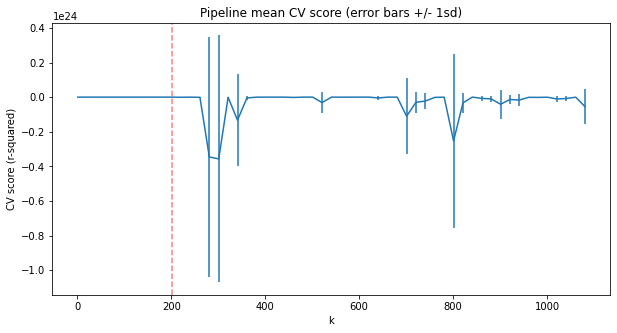

In [64]:
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [72]:
pipeLinear201 = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression, k=201),
    LinearRegression()
)

In [73]:
pipeLinear201.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('selectkbest',
                 SelectKBest(k=201,
                             score_func=<function f_regression at 0x1a1cb3a440>)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [77]:
y_pred201tr = pipeLinear201.predict(X_train)
y_pred201te = pipeLinear201.predict(X_test)

In [79]:
r2_score(y_train, y_pred201tr), r2_score(y_test, y_pred201te)

(0.41418313427887954, 0.4109796451152883)

In [78]:
mean_absolute_error(y_train, y_pred201tr), mean_absolute_error(y_test, y_pred201te)

(0.6692841493339317, 0.6653032993029445)

Interestingly enough, our metrics after fitting this model perform worse than our basic Linear Regression model. However this could be simply due to variation in model evaluation. While its metrics are worse, this model most likely at least does not overfit.

We will now examine our most influential coefficients of our linear model, taking the model that only selects the best k features.

In [156]:
# Determining names of best features
mask = pipeLinear201[1].get_support()
new_features = X_train.columns[mask]
best201 = new_features.tolist()

In [88]:
# Get list of model coefficients

lincoeffs = pipeLinear201[2].coef_.tolist()

# Map features to their coefficients
coeffs = {lincoeffs[i]: best201[i] for i in range(len(best201))}

In [89]:
# Create lists of positive and negative coefficients

positives = []
negatives = []

for lincoeff in lincoeffs:
    if lincoeff < 0:
        negatives.append(lincoeff)
    else:
        positives.append(lincoeff)
        
positives.sort(reverse=True)
negatives.sort()

Lets look at the features that contributed to increasing the price first. The features we expect to show up on this list are brands and categories that are more expensive in general. Let's see if this will be the case.

In [90]:
[coeffs[i] for i in positives[:10]]

['Category_Electronics/Cell Phones & Accessories/Cell Phones & Smartphones',
 'Brand_Kendra Scott',
 'Category_Men/Shoes/Athletic',
 'Brand_Lululemon',
 'Brand_Louis Vuitton',
 'Brand_Michael Kors',
 'Brand_LuLaRoe',
 'Category_Electronics/Video Games & Consoles/Consoles',
 'Category_Women/Shoes/Athletic',
 'Brand_Tory Burch']

In [92]:
positives[:10]

[0.15930881816667758,
 0.14269734751510632,
 0.1362409368962152,
 0.13017132657354952,
 0.1275030089420602,
 0.12217614101113024,
 0.11500486221549447,
 0.11196040323968483,
 0.10464090597239853,
 0.10117878968784459]

This is a good sign, we see luxury brands and categories that naturally would sell for higher prices. We feel rather confident in our linear regression model now. Let's also see the most negative features:

In [91]:
[coeffs[i] for i in negatives[:10]]

['Shipping',
 'Brand_FOREVER 21',
 'Category_Electronics/Cell Phones & Accessories/Cases, Covers & Skins',
 'Brand_Old Navy',
 'Category_Vintage & Collectibles/Trading Cards/Sports',
 'Brand_Disney',
 'Category_Beauty/Makeup/Lips',
 'Category_Women/Tops & Blouses/Blouse',
 'Brand_Hollister',
 'Category_Women/Tops & Blouses/Tank, Cami']

In [93]:
negatives[:10]

[-0.13660878262863058,
 -0.09047599092687497,
 -0.07540671933030954,
 -0.07055379680726412,
 -0.0622048290637069,
 -0.05419344155340529,
 -0.05176136690391171,
 -0.0516432897560628,
 -0.051341135023821594,
 -0.05117049467838955]

Also a good sign, the brands we see here are fairly average in terms of pricing, and the categories do correspond to more inexpensive items. Very interestingly enough, we see that Shipping ranks as the most negative coefficient. This means that when the seller pays for shipping, the item listing also tends to be lower priced on average. This is consistent with our observations during our EDA.

In conclusion, let's summarize the performance of our final Linear Regression model. We've discovered that only selecting k best features does improve the performance of the model compared to just using every feature. Therefore our final Linear Regression model will be our model that selects the 201 best features. Here are its R score, MAE, and MAPE.

In [95]:
# Linear Regression model R Score

r2_score(y_train, y_pred201tr), r2_score(y_test, y_pred201te)

(0.41418313427887954, 0.4109796451152883)

In [96]:
# Linear Regression model MAE

mean_absolute_error(y_train, y_pred201tr), mean_absolute_error(y_test, y_pred201te)

(0.6692841493339317, 0.6653032993029445)

In [97]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [98]:
mean_absolute_percentage_error(y_train, y_pred201tr), mean_absolute_percentage_error(y_test, y_pred201te)

(16.3929443440093, 16.35648495577335)

# Random Forest Model

Due to the constraints of our computational power, we cannot handle the default setting of max_depth=100. After much trial and error, I've decided on max_depth=50, which strikes a balance between code runtime and performance.

In [54]:
# Defining a pipeline for a random forest model

RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(max_depth=50, n_estimators=15)
)

In [55]:
# Fitting pipeline

RF_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=50,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=15, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [ ]:
# Predicting with RF model
y_predRFtr = RF_pipe.predict(X_train)
y_predRFte = RF_pipe.predict(X_test)

In [57]:
r2_score(y_train, y_predRFtr), r2_score(y_test, y_predRFte)

(0.408128407615975, 0.37491119258967387)

In [58]:
mean_absolute_error(y_train, y_predRFtr), mean_absolute_error(y_test, y_predRFte)

(0.6721901422229208, 0.6843152360244126)

Not bad as a base Random Forest model, let's now do some tuning in regards to the number of estimators, or trees. Ideally we would use GridSearchCV to do this more systematically, but unfortunately we don't have to computational power to do that. So instead we'll have to manually improve our model through trial and error.

In [115]:
RF_pipe1 = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(max_depth=50, n_estimators=50)
)

In [116]:
RF_pipe1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=50,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=50, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [117]:
# Predicting with RF model
y_predRFtr = RF_pipe1.predict(X_train)
y_predRFte = RF_pipe1.predict(X_test)

In [118]:
r2_score(y_train, y_predRFtr), r2_score(y_test, y_predRFte)

(0.409339684227923, 0.37642437419118746)

Seems like there are very diminishing returns on adding more estimators.

In [119]:
RF_pipe2 = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(max_depth=60, n_estimators=50)
)

In [120]:
RF_pipe2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=60,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=50, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [121]:
# Predicting with RF model
y_predRFtr = RF_pipe2.predict(X_train)
y_predRFte = RF_pipe2.predict(X_test)

In [122]:
r2_score(y_train, y_predRFtr), r2_score(y_test, y_predRFte)

(0.43184299469881904, 0.393068555844467)

It turns out that increasing the max_depth of the trees has far greater returns on performance compared adding more trees. Let's try adjusting max_depth more instead.

In [123]:
RF_pipe3 = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(max_depth=100, n_estimators=50)
)

In [124]:
RF_pipe3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=100,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=50, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [125]:
# Predicting with RF model
y_predRFtr = RF_pipe3.predict(X_train)
y_predRFte = RF_pipe3.predict(X_test)

In [126]:
r2_score(y_train, y_predRFtr), r2_score(y_test, y_predRFte)

(0.4845294606465418, 0.42932706449496616)

Looking good, we'll do one last large increase of max_depth and go with that.

In [127]:
RF_pipe4 = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(max_depth=200, n_estimators=50)
)

In [128]:
RF_pipe4.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=200,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=50, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [129]:
# Predicting with RF model
y_predRFtr = RF_pipe4.predict(X_train)
y_predRFte = RF_pipe4.predict(X_test)

In [130]:
r2_score(y_train, y_predRFtr), r2_score(y_test, y_predRFte)

(0.5352083165172818, 0.45844209462714314)

In [131]:
mean_absolute_error(y_train, y_predRFtr), mean_absolute_error(y_test, y_predRFte)

(0.5880756292478646, 0.633345754478913)

Looks good! We have an R score of 0.458 now, and the lowest MAE so far. Let's take a look at what our most important features were.

In [141]:
important_features = pd.Series(data=RF_pipe4[1].feature_importances_,index=X_train.columns)
important_features.sort_values(ascending=False,inplace=True)
important_features[:15]

Shipping                                                                    0.058390
Category_Electronics/Cell Phones & Accessories/Cell Phones & Smartphones    0.039730
Category_Men/Shoes/Athletic                                                 0.035203
Brand_Michael Kors                                                          0.033555
Brand_Louis Vuitton                                                         0.030098
Brand_Lululemon                                                             0.023174
Brand_LuLaRoe                                                               0.022592
Brand_Kendra Scott                                                          0.020584
Category_Electronics/Video Games & Consoles/Consoles                        0.018053
Category_Women/Shoes/Boots                                                  0.017924
Category_Electronics/Computers & Tablets/Laptops & Netbooks                 0.016641
Brand_Tory Burch                                                 

In [144]:
featurenames = ['Shipping',
                'Electronics/Cell Phones & Accessories/Cell Phones & Smartphones',
                'Men/Shoes/Athletic',
                'Michael Kors',
                'Louis Vuitton',
                'Lululemon',
                'LuLaRoe',
                'Kendra Scott',
                'Electronics/Video Games & Consoles/Consoles',
                'Women/Shoes/Boots',
                'Electronics/Computers & Tablets/Laptops & Netbooks',
                'Tory Burch',
                'Women/Shoes/Athletic',
                'FOREVER 21',
                'Kate Spade']

featureweights = important_features[:15]

<BarContainer object of 15 artists>

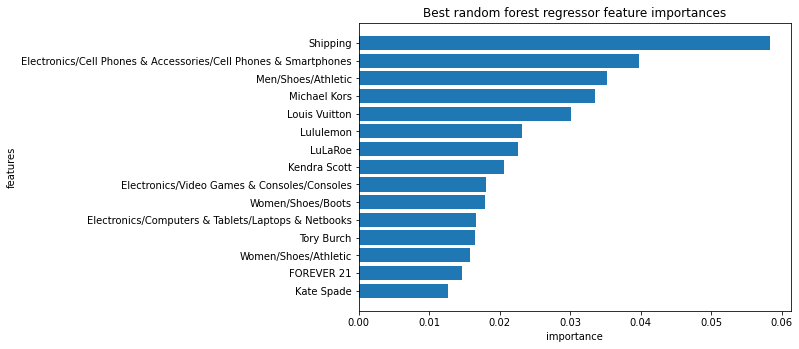

In [154]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('features')
ax.set_xlabel('importance')
ax.set_title('Best random forest regressor feature importances')
ax.invert_yaxis()
ax.barh(featurenames, featureweights)

This is looking great and intuitive, the features here do in fact appear to be the more expensive brands and categories. Shipping once again shows up as a major influencer here, like it did as well when we examined our linear regression model. 

# Final Model Selection

Linear Regression Model:

In [95]:
# Linear Regression model R Score
r2_score(y_train, y_pred201tr), r2_score(y_test, y_pred201te)

(0.41418313427887954, 0.4109796451152883)

In [96]:
# Linear Regression model MAE
mean_absolute_error(y_train, y_pred201tr), mean_absolute_error(y_test, y_pred201te)

(0.6692841493339317, 0.6653032993029445)

In [157]:
# Linear Regression model MAPE
mean_absolute_percentage_error(y_train, y_pred201tr), mean_absolute_percentage_error(y_test, y_pred201te)

(16.3929443440093, 16.35648495577335)

Random Forest Model:

In [158]:
# Random Forest model R Score
r2_score(y_train, y_predRFtr), r2_score(y_test, y_predRFte)

(0.5352083165172818, 0.45844209462714314)

In [159]:
# Random Forest model MAE
mean_absolute_error(y_train, y_predRFtr), mean_absolute_error(y_test, y_predRFte)

(0.5880756292478646, 0.633345754478913)

In [160]:
# Random Forest model MAPE
mean_absolute_percentage_error(y_train, y_predRFtr), mean_absolute_percentage_error(y_test, y_predRFte)

(14.301615741216953, 15.482469435507767)

# Conclusion

It's very clear cut, our Random Forest model performs better than our Linear Regression model across all metrics.

In [161]:
# Saving model
best_model = RF_pipe4[1]
best_model.version = '1.0'
best_model.pandas_version = 'pd._version_'
best_model.numpy_version = 'np._version_'
best_model.sklearn_version = 'sklearn_version'
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = 'datetime.datetime.now()'
    
modelpath = 'models'
if not os.path.exists(modelpath):
    os.mkdir(modelpath)
mercariRFmodel_path = os.path.join(modelpath, 'mercariRFmodel.pkl')
if not os.path.exists(mercariRFmodel_path):
    with open(mercariRFmodel_path, 'wb') as f:
        pickle.dump(best_model, f)